In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wcpredictor

In this notebook, we look at different values of `epsilon` and `world_cup_weight`. We always have 20 years worth of training data and use FIFA organisation ratings.

In [65]:
def get_loss_value(filename, agg = "mean"):
    losses = np.fromfile(filename, dtype=float, sep='\n')
    if agg == "mean":
        agg_loss = losses.mean()
    elif agg == "sum":
        agg_loss = losses.sum()
    return agg_loss

def get_all_metrics(input_dir, method, epsilon_trialed, world_cup_weight_trialed, all_comps, agg_method = "mean"):
    filenames = os.listdir(input_dir)
    filenames = [f for f in filenames if "_loss.txt" in f]
    vals = {"epsilon": [], "world_cup_weight": [], "loss": []}
    for ep in epsilon_trialed:
        for wc in world_cup_weight_trialed:
            vals["epsilon"].append(ep)
            vals["world_cup_weight"].append(wc)
            if all_comps:
                filename = f"womens_{method}_20_org_all_comps_ep_{ep}_wc_{wc}.txt"
            else:
                filename = f"womens_{method}_20_org_no_friendlies_ep_{ep}_wc_{wc}.txt"
            loss = get_loss_value(os.path.join(input_dir, filename), agg_method)
            vals["loss"].append(loss)
    print
    df = pd.DataFrame(vals)
    return df

def plot_winner(input_csv):
    df = pd.read_csv(input_csv)
    df.sort_values(by="W", axis=0, ascending=False, inplace=True)
    # plot the top ten
    df = df[:10]
    fig, ax = plt.subplots(tight_layout=True)
    xvals = list(df.Team.values)
    yvals = list(df.W.values)
    ax.bar(xvals, yvals)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
    ax.set_ylabel("Number of wins")
    plt.show()
    
def get_progression_probabilities(input_csv, n_sim):
    df = pd.read_csv(input_csv)
    df.sort_values(by="W", axis=0, ascending=False, inplace=True)
    vals = {"team": [], "R16": [], "QF": [], "SF": [], "F": [], "W": []}
    for team in df["Team"]:
        vals["team"].append(team)
        vals["R16"].append(df[df["Team"]==team].iloc[0][["R16", "QF", "SF", "RU", "W"]].sum()/n_sim)
        vals["QF"].append(df[df["Team"]==team].iloc[0][["QF", "SF", "RU", "W"]].sum()/n_sim)
        vals["SF"].append(df[df["Team"]==team].iloc[0][["SF", "RU", "W"]].sum()/n_sim)
        vals["F"].append(df[df["Team"]==team].iloc[0][["RU", "W"]].sum()/n_sim)
        vals["W"].append(df[df["Team"]==team].iloc[0][["W"]].sum()/n_sim)
    return pd.DataFrame(vals)

## RPS score

Here, we again use 20 years worth of training data and use the last 3 years as test data. We obtain the model outcome predictions for each game in the last two years and compute the Rank Probability Score for each game. We take either the average, or sum, RPS over the games to get a final metric.

In [12]:
epsilon_trialed = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
world_cup_weight_trialed = [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]

```
wcpred_forecast_evaluation --womens --metric="rps" --years_training=20 --years_testing=3 --ratings_choices="org" --epsilon_choices=0.0,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,3.0,4.0,5.0 --world_cup_weight_choices=1.0,2.0,3.0,4.0,5.0,10.0 --output_dir="rps_output" --num_thread=6 --exclude_friendlies
```

In this setting, we have:

```
start / end dates for training period are: 2003-06-01, 2020-05-31
start / end dates for test period are: 2020-06-01, 2023-06-01
```

<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

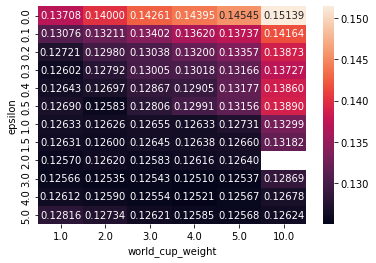

In [70]:
rps_data = get_all_metrics("../rps_output_exclude_friendlies/",
                           "rps",
                           epsilon_trialed,
                           world_cup_weight_trialed,
                           all_comps=True)
fp = rps_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".5f")

In [71]:
rps_data[rps_data["loss"]==rps_data["loss"].min()]

,epsilon,world_cup_weight,loss
57,3.0,4.0,0.125098


<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

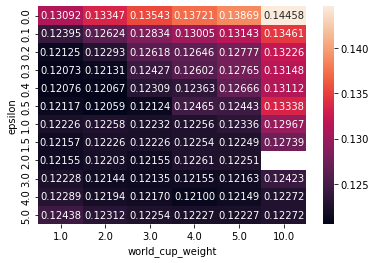

In [72]:
rps_data = get_all_metrics("../rps_output_exclude_friendlies/",
                           "rps",
                           epsilon_trialed,
                           world_cup_weight_trialed,
                           all_comps=False)
fp = rps_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".5f")

In [73]:
rps_data[rps_data["loss"]==rps_data["loss"].min()]

,epsilon,world_cup_weight,loss
31,0.5,2.0,0.120591


This seems to suggest that around `epsilon=3.0` and `world_cup_weight=4.0` is the best if we include all competitions in our data, but `epsilon=0.5` and `world_cup_weight=2.0` if we exclude friendly matches - but note that many values actually give incredibly close average RPS scores. So it seems actually that any combination which includes a higher value of `epsilon` and/or `world_cup_weight` would be good.

```
wcpred_run_simulations --womens --tournament_year=2023 --num_simulations=10000 --years_training_data=20 --resume_from=Group --output_csv="ep_3_wc_4.csv" --ratings_source="org" --epsilon=3 --world_cup_weight=4
```

Since we're starting simulation from the Group stage, the test and training years are:

```
start_date: 2003-06-01
end_date: 2023-07-20
```

Note that `2023-07-20` is the start of the Women's 2023 World Cup.

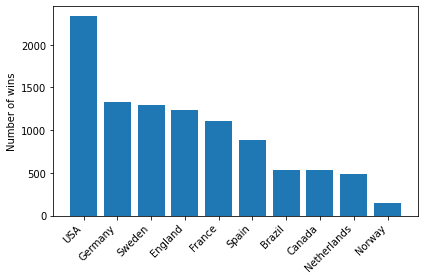

In [81]:
plot_winner("../ep_3_wc_4.csv")

In [82]:
get_progression_probabilities("../ep_3_wc_4.csv", 10000)

,team,R16,QF,SF,F,W
0,USA,0.9538,0.7303,0.5740,0.3747,0.2333
1,Germany,0.9891,0.6212,0.3938,0.2373,0.1332
2,Sweden,0.9716,0.5844,0.3987,0.2349,0.1294
3,England,0.9690,0.7450,0.3998,0.2409,0.1240
4,France,0.9833,0.7096,0.4426,0.2324,0.1108
5,Spain,0.9846,0.7969,0.3705,0.1870,0.0882
6,Brazil,0.9685,0.5756,0.3105,0.1278,0.0533
7,Canada,0.8969,0.5692,0.2847,0.1270,0.0528
8,Netherlands,0.8782,0.4743,0.2964,0.1174,0.0481
9,Norway,0.9917,0.6108,0.1885,0.0562,0.0147


```
wcpred_run_simulations --womens --tournament_year=2023 --num_simulations=100000 --years_training_data=20 --resume_from=Group --output_csv="ep_0.5_wc_2.csv" --ratings_source="org" --epsilon=0.5 --world_cup_weight=2
```

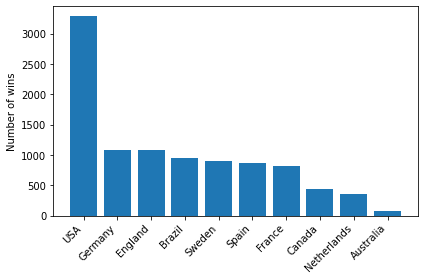

In [78]:
plot_winner("../ep_0.5_wc_2.csv")

In [80]:
get_progression_probabilities("../ep_0.5_wc_2.csv", 10000)

,team,R16,QF,SF,F,W
0,USA,0.9797,0.8172,0.6871,0.4915,0.3286
1,Germany,0.9807,0.5698,0.3622,0.2232,0.1089
2,England,0.9589,0.7061,0.3752,0.2204,0.1084
3,Brazil,0.9869,0.6704,0.4188,0.2081,0.0943
4,Sweden,0.9596,0.5394,0.3535,0.1728,0.0897
5,Spain,0.9834,0.8229,0.3968,0.1818,0.0859
6,France,0.9881,0.6471,0.4048,0.1943,0.0820
7,Canada,0.8832,0.5589,0.2549,0.1102,0.0434
8,Netherlands,0.8749,0.4635,0.2624,0.0896,0.0347
9,Australia,0.7442,0.3270,0.0801,0.0266,0.0067


## Brier score

Here, we again use 20 years worth of training data and use the last 3 years as test data. We obtain the model outcome predictions for each game in the last two years and compute the Brier Score for each game. We take either the average, or sum, RPS over the games to get a final metric.

```
wcpred_forecast_evaluation --womens --metric="brier" --years_training=20 --years_testing=3 --ratings_choices="org" --epsilon_choices=0.0,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,3.0,4.0,5.0 --world_cup_weight_choices=1.0,2.0,3.0,4.0,5.0,10.0 --output_dir="brier_output_exclude_friendlies" --num_thread=6 --exclude_friendlies
```

<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

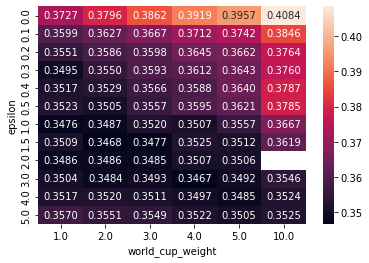

In [74]:
brier_data = get_all_metrics("../brier_output_exclude_friendlies/",
                             "brier",
                             epsilon_trialed,
                             world_cup_weight_trialed,
                             all_comps=True)
fp = brier_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".4f")

In [75]:
brier_data[brier_data["loss"]==brier_data["loss"].min()]

,epsilon,world_cup_weight,loss
57,3.0,4.0,0.346748


<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

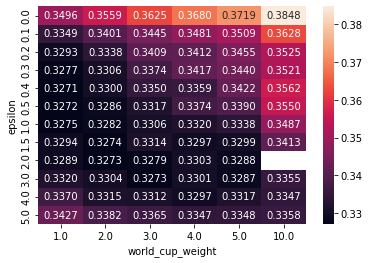

In [76]:
brier_data = get_all_metrics("../brier_output_exclude_friendlies/",
                             "brier",
                             epsilon_trialed,
                             world_cup_weight_trialed,
                             all_comps=False)
fp = brier_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".4f")

In [77]:
brier_data[brier_data["loss"]==brier_data["loss"].min()]

,epsilon,world_cup_weight,loss
24,0.4,1.0,0.327078
